In [18]:
import matplotlib
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [19]:
def load_images_as_array(file_paths):
    """
    Load images from file paths and save them as a NumPy array.

    Parameters:
    - file_paths (list): List of file paths for the images.

    Returns:
    - images_array (numpy.ndarray): NumPy array containing the images.
    """

    # Initialize an empty list to store individual image arrays
    images_list = []

    # Loop through each file path and load the image
    for file_path in file_paths:
        try:
            # Open the image using PIL
            img = Image.open(file_path)

            # Convert the image to a NumPy array
            img_array = np.array(img)

            # Append the array to the list
            images_list.append(img_array)
        except Exception as e:
            print(f"Error loading image at {file_path}: {e}")

    return images_list

# Example usage:
file_paths = ["./images/crack1.jpg", "./images/crack2.jpeg", "./images/crack3.jpg"]
loaded_images = load_images_as_array(file_paths)

def convert_to_cv2(np_img): 
    cv2_image = cv.cvtColor(np_img, cv2.IMREAD_GRAYSCALE)
    return cv2_image

# Image processing methods

Hough transform in OpenCV: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
Find curves on the image: https://pushkin.faculty.unlv.edu/ece5554/lecture7.pdf
Lines and curves detection: https://sites.ecse.rpi.edu/~qji/CV/HTX.pdf
Lines and curves detection: https://homepages.inf.ed.ac.uk/rbf/BOOKS/BANDB/LIB/bandb4_3.pdf




In [140]:
def blur_image(image, kernel_size=(5, 5)):
    blurred_image = cv.GaussianBlur(image, kernel_size, 0)
    return blurred_image

def img_proc(img, show=True):
    img = cv.imread(img, cv.IMREAD_GRAYSCALE)
    # Blur image 
    blur_xk = 21
    img = blur_image(img, (blur_xk, blur_xk))
    # Canny edge detection
    canny_min = 50; canny_max = 100; 
    edges = cv.Canny(img, 50, 100)
    # Plot images
    if show: 
        plt.figure(figsize=(15, 10))
        plt.subplot(121),plt.imshow(img,cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(edges,cmap = 'gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
        plt.show()
    return edges

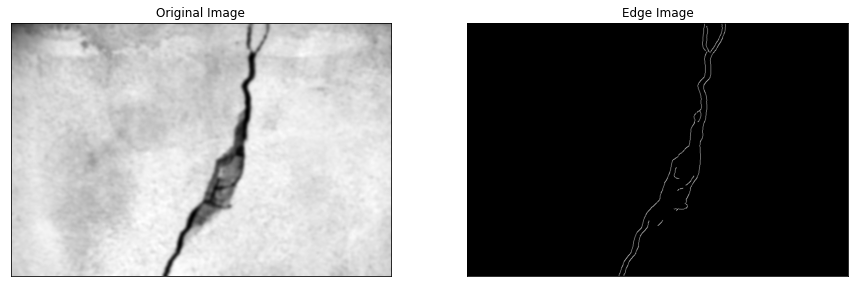

In [141]:
edge1 = img_proc(file_paths[0], show=True)
edge2 = img_proc(file_paths[1], show=False)
edge3 = img_proc(file_paths[2], show=False)

In [361]:
def show_img(img): 
    plt.imshow(img,cmap = 'gray')
    plt.title('Original Image')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    
def show_imgs(edges, pts): 
    # Create a figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # Plot the first horizontal subplot
    ax1.imshow(edges, cmap='gray')
    ax1.set_title('Edges image')

    # Plot the second horizontal subplot
    ax2.scatter(pts[:, 0], pts[:, 1], color='green')
    #ax2.set_xlim([0, 1000]); ax2.set_ylim([0, 600])

    # Set common labels and show the figure
    plt.tight_layout()  # Adjust layout to prevent clipping of titles
    plt.show()

def hough_lines(edges, dividor, show=False): 
    num_votes = int(min(edges.shape)/dividor)
    lines = cv2.HoughLines(edges,1,np.pi/180, num_votes)
    print(f"Number of detected lines for {num_votes} votes is: {len(lines)}")
    for line in lines[:1]: 
        print(line)
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(edges,(x1,y1),(x2,y2),(255,255,255), 2)
    
    if show: 
        show_img(edges)

    return lines

# THIS IS GOOD ONE [GIVES POINTS!]
# EXTRACT THOSE POINTS AND PREFORM POLYNOMIAL REGRESSION TO FIND PATH [CHECK DURATION]
def hough_lines_p(edges, dividor, show): 
    num_votes = int(min(edges.shape)/dividor)
    minLineLength = 30; maxLineGap = 5
    lines = cv2.HoughLinesP(edges,cv2.HOUGH_PROBABILISTIC, np.pi/180, num_votes, minLineLength, maxLineGap)
    print(f"Number of detected lines for {num_votes} votes is: {len(lines)}")
    pts_ = None
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            p1 = np.array([x1, y1]); p2 = np.array([x2, y2])
            if x == 0:
                pts_ = np.vstack((p1, p2))
            else: 
                pts_ = np.vstack((pts_, p1, p2))
            #cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
            pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
            cv2.polylines(edges, [pts], True, (255,255,255), 3)
    if show: 
        show_imgs(edges, pts_)
        
    return pts_


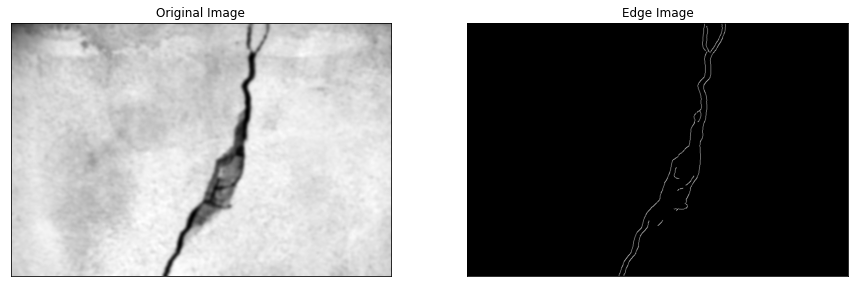

Number of detected lines for 21 votes is: 51


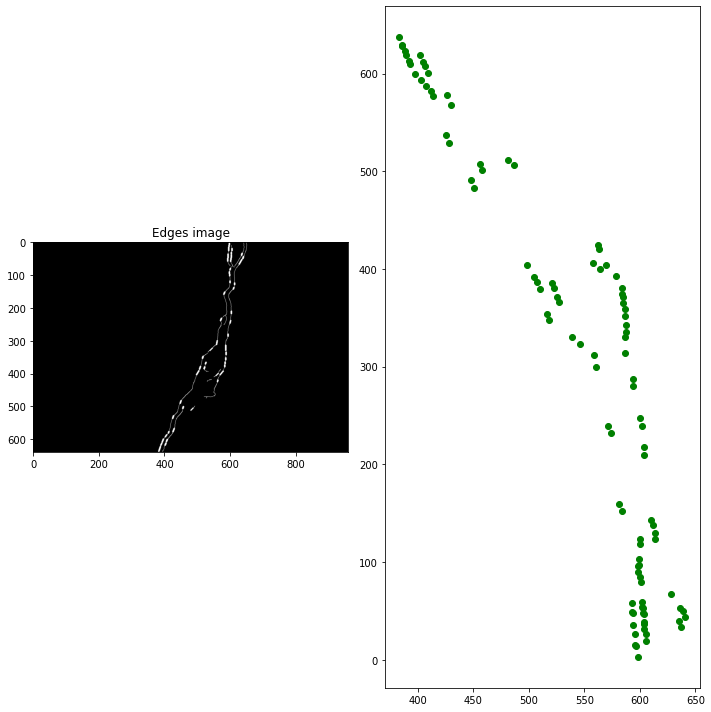

In [420]:
edge1 = img_proc(file_paths[0], show=True)
d_ = 30
pts1 = hough_lines_p(edge1, d_, True)

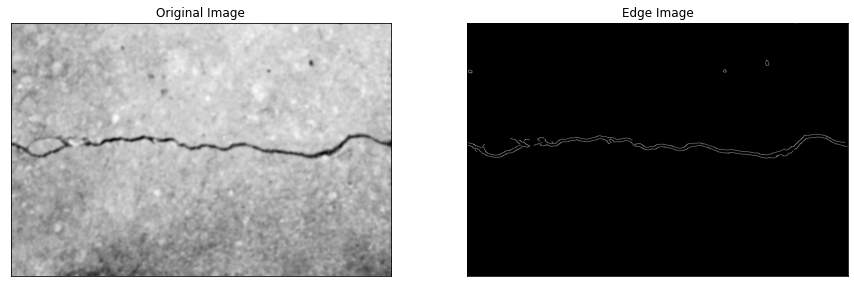

Number of detected lines for 80 votes is: 16


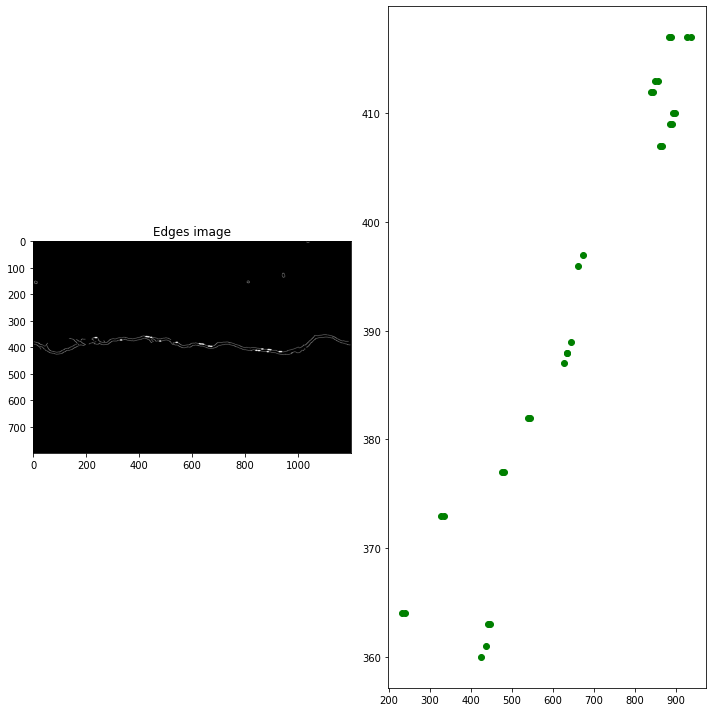

In [421]:
d_ = 10
edge2 = img_proc(file_paths[1])
pts2 = hough_lines_p(edge2, d_, True)

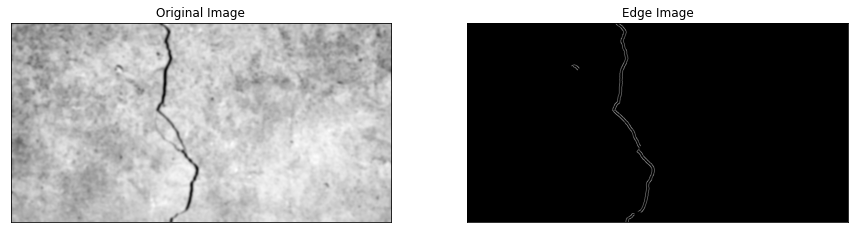

Number of detected lines for 21 votes is: 54


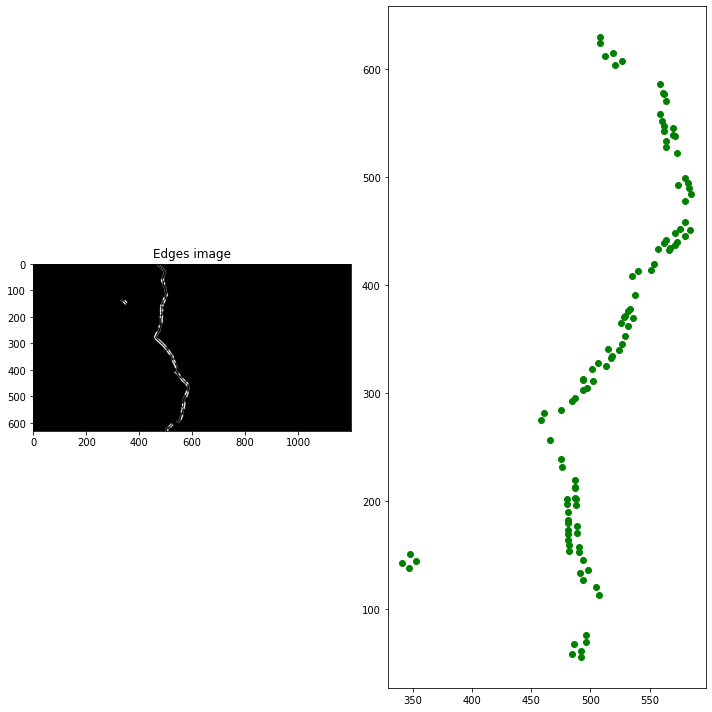

In [422]:
d_ = 30
edge3 = img_proc(file_paths[2])
pts3 = hough_lines_p(edge3, d_, True)

In [514]:
import time

def sortxy(pts):
    x = pts[:, 1]; y = pts[:, 0]
    # Create a list of tuples (value, index)
    sort_x = list(zip(x, range(len(x))))
    # Sort the list of tuples based on values
    sort_xix = sorted(sort_x, key=lambda x: x[0])
    # Unzip the sorted tuples
    x, ix = zip(*sort_xix)
    # Use the sorted indexes to reorder the other list
    sort_y = [y[i] for i in ix]
    return x, sort_y

def polynomial_fitting(pts, order): 
    start_time = time.time()
    # TODO: Speed up by sorting just one time :) 
    x, y = sortxy(pts)
    p = np.polyfit(x, y, order)
    f = np.poly1d(p)
    x_new = np.linspace(min(x), max(x), num=len(list(x)))
    y_new = f(x_new)
    end_time = time.time()
    t = end_time - start_time
    print(f"Duration of order {order}: {t}")
    
    plt.figure()
    plt.scatter(x, y)
    plt.plot(x_new, y_new)
    return y, y_new

def check_error(y, y_new): 
    e = np.sqrt(np.sum((y-y_new)**2))
    print(f"Error is: {e}")

Duration of order 0: 0.0008802413940429688
Error is: 2081.57388606248
Duration of order 1: 0.0004436969757080078
Error is: 1082.053434416213
Duration of order 2: 0.0002849102020263672
Error is: 1310.8078627190323
Duration of order 3: 0.0004673004150390625
Error is: 1290.6102877714397
Duration of order 4: 0.0006237030029296875
Error is: 1331.531987869781
Duration of order 5: 0.0004901885986328125
Error is: 1359.076700752021
Duration of order 6: 0.000461578369140625
Error is: 1404.011947241833
Duration of order 7: 0.0005674362182617188
Error is: 1403.1792357349625
Duration of order 8: 0.0003905296325683594
Error is: 1462.7294183856616
Duration of order 9: 0.0004229545593261719
Error is: 1437.1878131966698
Duration is: 0.14124798774719238


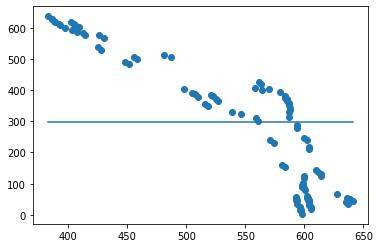

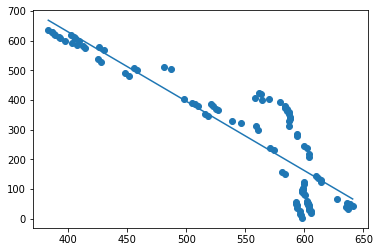

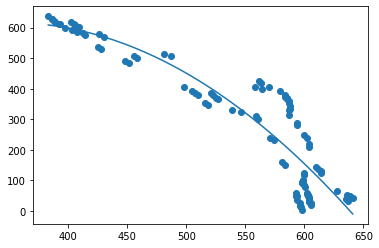

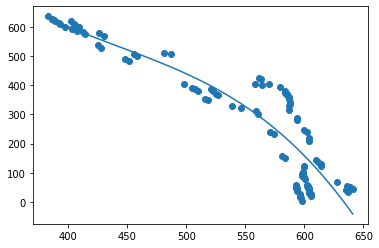

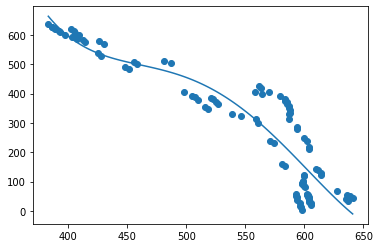

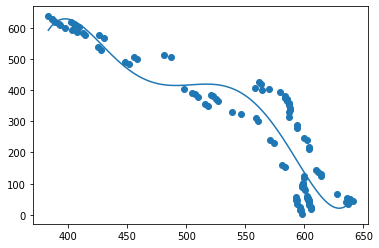

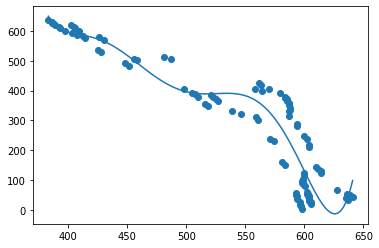

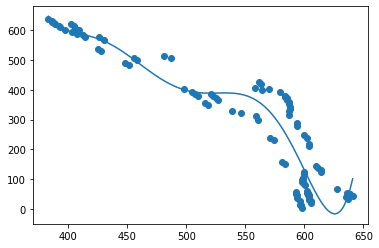

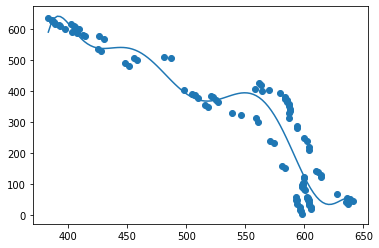

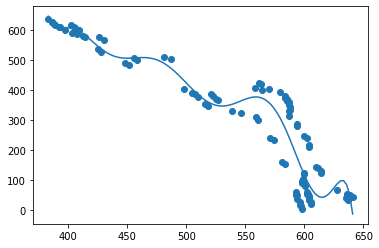

In [512]:
#polynomial_fitting(pts1, 2); polynomial_fitting(pts1, 3); polynomial_fitting(pts1, 4)

# 0.15 sekundi duration da prodje kroz X tocaka 
orders = list(range(0, 10))
start_t = time.time()
for o in orders:
    y, y_new = polynomial_fitting(pts1, o)
    check_error(y, y_new)
    end_t = time.time()
print(f"Duration is: {end_t - start_t}")


Duration of order 0: 0.0008544921875
Error is: 1671.6021229369767
Duration of order 1: 0.0003819465637207031
Error is: 1722.3590517913326
Duration of order 2: 0.0003676414489746094
Error is: 1555.8120946808724
Duration of order 3: 0.0002856254577636719
Error is: 1991.7123321712206
Duration of order 4: 0.0004062652587890625
Error is: 1546.173324099415
Duration of order 5: 0.0004730224609375
Error is: 1522.1352162165992
Duration of order 6: 0.00034546852111816406
Error is: 2562.1507642821907
Duration of order 7: 0.00031685829162597656
Error is: 6784.014936315379
Duration of order 8: 0.00040459632873535156
Error is: 4122.200291461748
Duration of order 9: 0.001146078109741211
Error is: 6455.638341977941


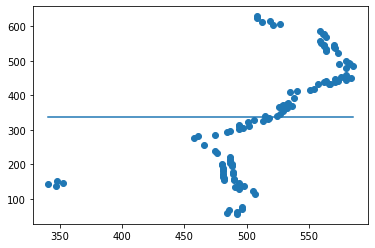

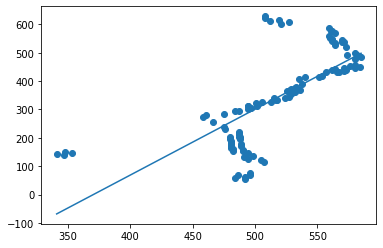

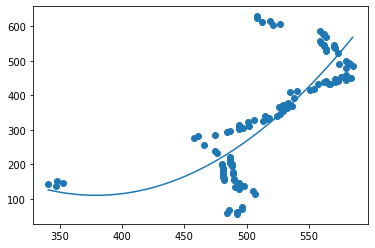

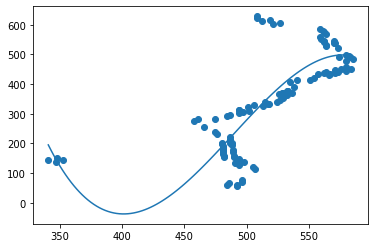

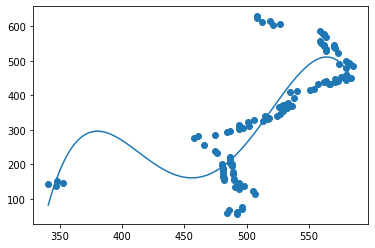

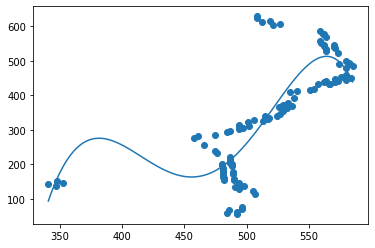

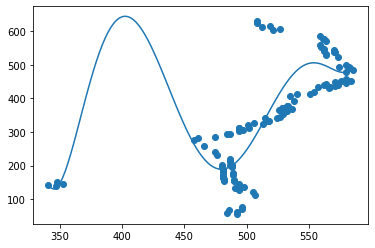

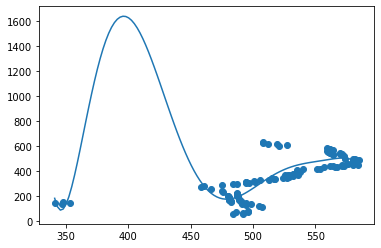

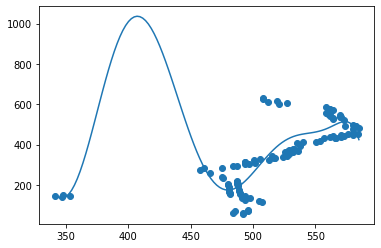

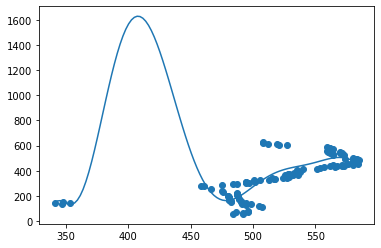

In [513]:
orders = list(range(0, 10))
for o in orders: 
    y, y_new = polynomial_fitting(pts3, o)
    check_error(y, y_new)